In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import importlib
from tqdm.auto import tqdm
matplotlib.rcParams['figure.figsize']=5,5
from time import sleep

# References

- [Climate Simulation Review](https://www.geo.uni-bremen.de/~apau/ecolmas_modeling2/mcguffie_henderson_sellers_2001.pdf)

- [Iceage Simulation 1973](https://journals.ametsoc.org/view/journals/apme/13/3/1520-0450_1974_013_0305_sotacu_2_0_co_2.xml?tab_body=pdf)

- [NCAR Circulation Model 1967](https://journals.ametsoc.org/view/journals/mwre/95/7/1520-0493_1967_095_0389_nggcmo_2_3_co_2.xml?tab_body=pdf)

- [NCAR Cloud](https://www.researchgate.net/publication/234292870_General_Circulation_Experiments_with_a_Six-Layer_NCAR_Model_Including_Orography_Cloudiness_and_Surface_Temperature_Calculations)

- [GPU Gems 3 Fluid Simulation](https://developer.nvidia.com/gpugems/gpugems3/part-v-physics-simulation/chapter-30-real-time-simulation-and-rendering-3d-fluids)

- [Ceyron's Numpy Fluid Simulation Code](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/simulation_scripts/stable_fluids_python_simple.py)

- [Spherical Coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system#Integration_and_differentiation_in_spherical_coordinates)

- [Fluid Sphere](https://www.dropbox.com/s/excugsw43c9rxjd/spherical_fluid_PACM.pdf?dl=0)

- [Cloud Model](https://www.atmos.albany.edu/facstaff/rfovell/ATM562/soong-ogura-1973.pdf)


In [2]:
importlib.reload(importlib.import_module('fluid3D'))
from fluid3D import *
importlib.reload(importlib.import_module('cloudModel'))
from cloudModel import *

In [3]:
%matplotlib inline


viscosity=0


xyz=get_positions()
u=np.zeros_like(xyz)
u+=taylor_green_vortex()*1
u+=laminar_flow()*1
dy,dz=xyz[...,1]-.5,xyz[...,2]-.5
dye=np.where(dy**2+dz**2<.1**2,1,0)
#u+=diffused_noise(u.shape)*.01
p=None
time=0




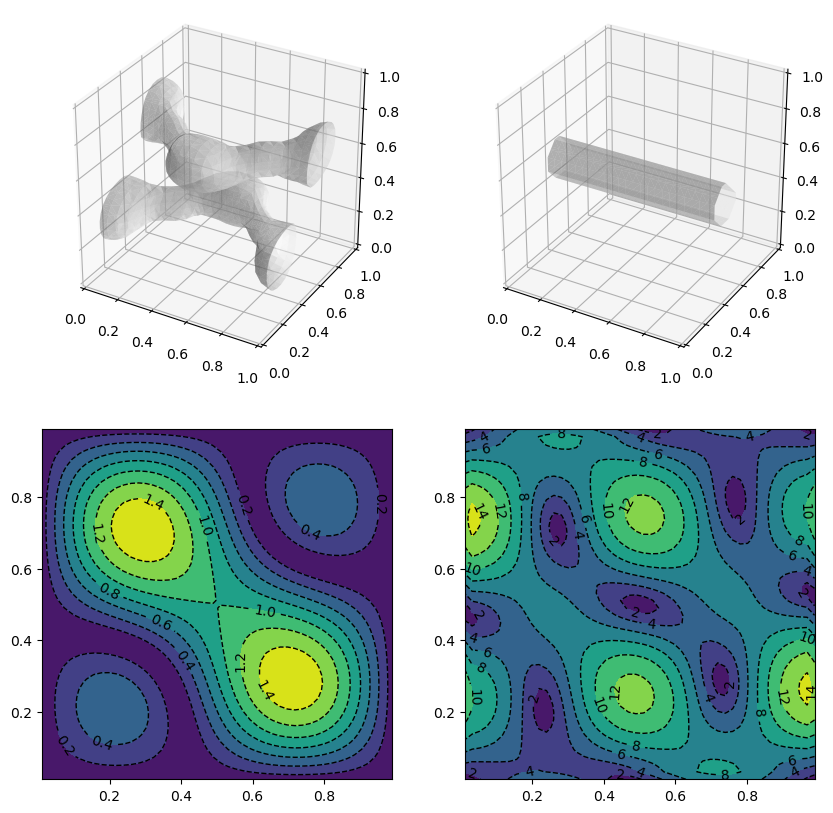

In [4]:
%matplotlib inline
def draw():
    plt.gcf().add_subplot(2,2,1,projection='3d')
    vorticity=curl(u)
    show_isosurface(u,rel_level=.9,step_res=24,alpha=.5)
    plt.gcf().add_subplot(2,2,2,projection='3d')
    show_isosurface(dye,abs_level=.3,step_res=24,alpha=.5)
    plt.gcf().add_subplot(2,2,3)
    show_contour_section(xyz,u)
    plt.gcf().add_subplot(2,2,4)
    show_contour_section(xyz,vorticity)

plt.figure(figsize=(10,10),dpi=100)
draw()
plt.show()
    

<IPython.core.display.Javascript object>


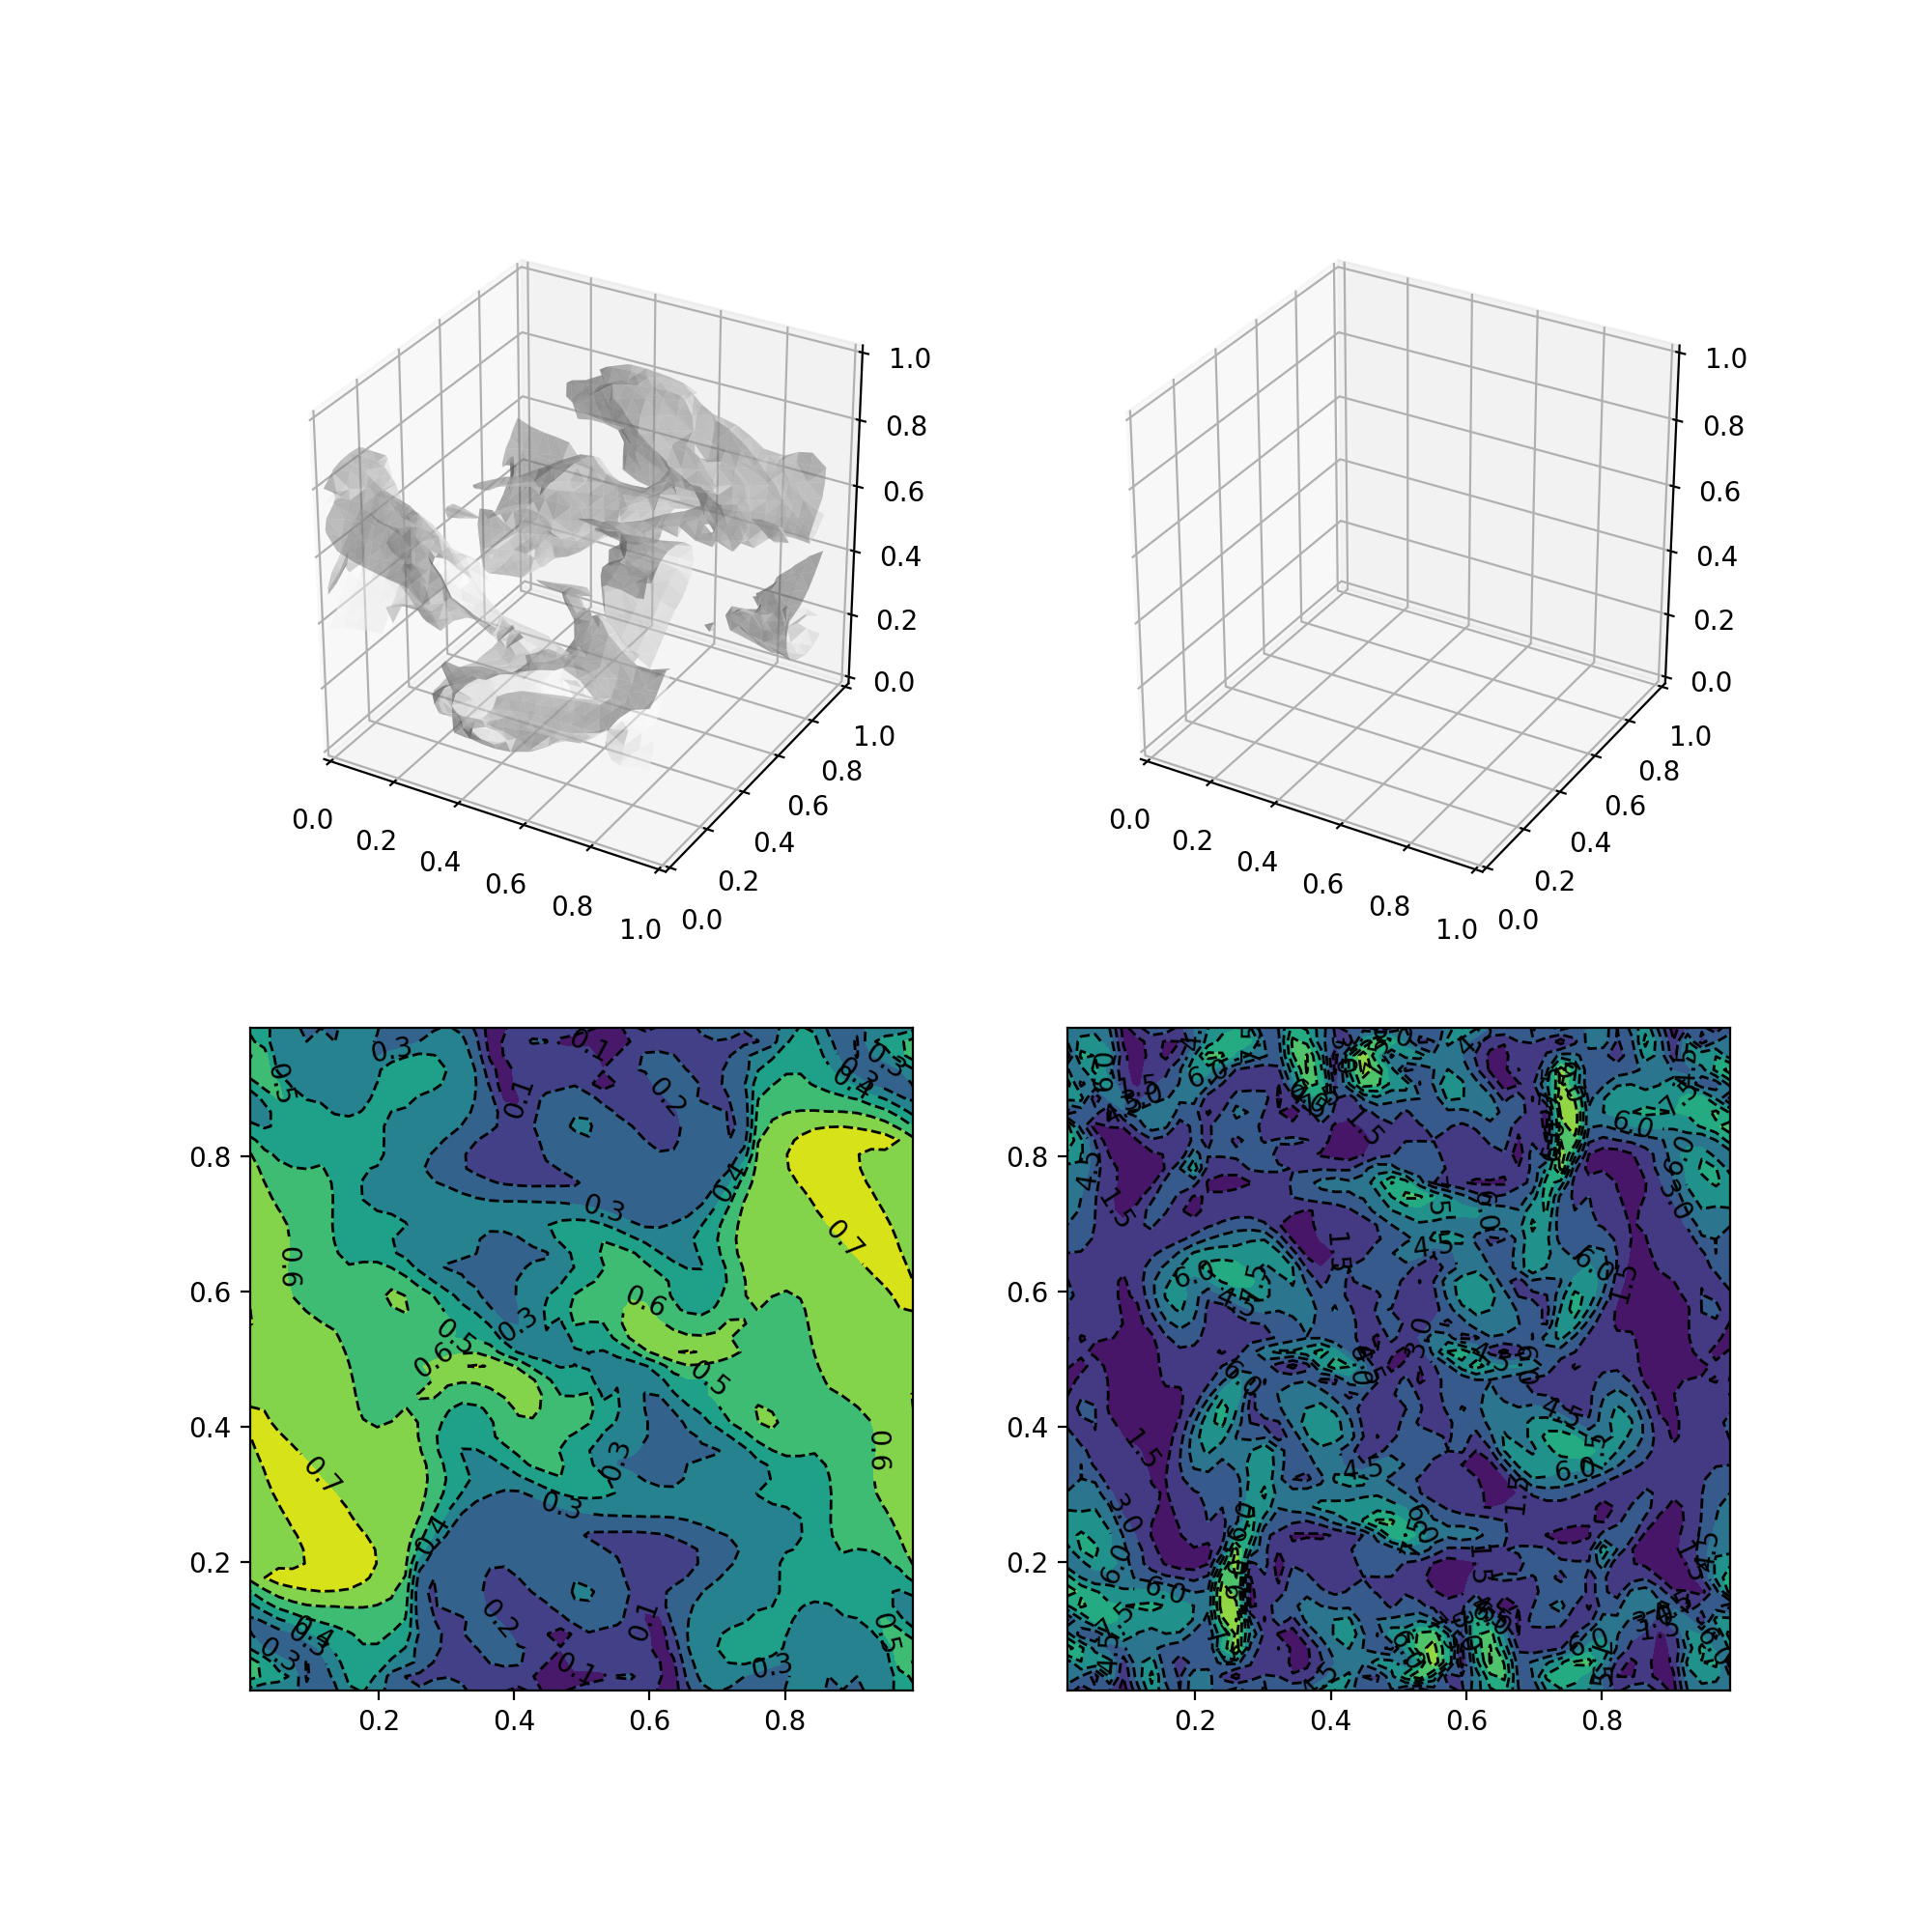

  0%|          | 0/6000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
%matplotlib notebook


fig=plt.figure(figsize=(10,10),dpi=100)
plt.ion()
def update_graph():
    plt.clf()
    draw()
    fig.canvas.draw()

for _iter in tqdm(range(6000)):
    if _iter%10==0:
        update_graph()
    
    dye=advect(dye,u)
    u=advect_velocity_MacCormack(u)
    
    u=diffuse(u,amount=viscosity*timeStep,nIter=5)
    

    u,p=solve_pressure(u,density=1,nIter=10,old_pressure=p)
    
    time=time+timeStep

# Atmospheric Model and Water Transportation

In [13]:
importlib.reload(importlib.import_module('fluid3D'))
from fluid3D import *
importlib.reload(importlib.import_module('cloudModel'))
from cloudModel import *
from perlin_numpy import (
    generate_fractal_noise_2d, generate_fractal_noise_3d,
    generate_perlin_noise_2d, generate_perlin_noise_3d
)

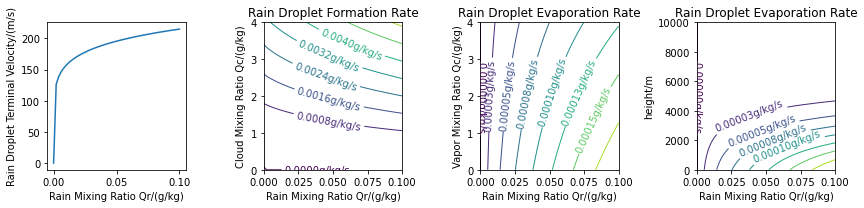

In [14]:
%matplotlib inline
show_rain_models()

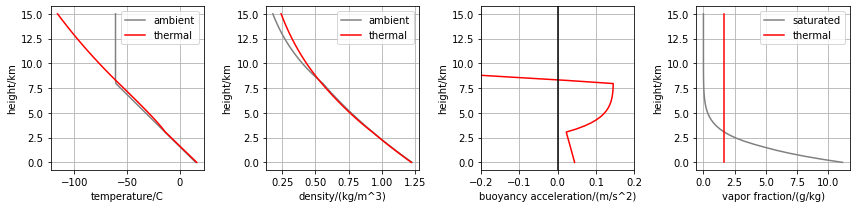

In [15]:
%matplotlib inline

desc=Atmosphere_Model_Desc(L0=gravity_constant/air_heat_capacity_isobaric-.0002,T_thermal=sea_level_temperature+1,RH_thermal=.15)
heights=np.linspace(0,15000)
pbar,rhobar,Tbar=atmosphere_model(heights,desc=desc)
show_buoyancy_analysis(heights=heights,T0=desc.T_thermal,RH0=desc.RH_thermal,Tbar=Tbar,pbar=pbar)

In [16]:

    

import fluid3D
fluid3D.gridRes=(48,48,64)
fluid3D.cellSizes=(24000/fluid3D.gridRes[0],24000/fluid3D.gridRes[1],16000/fluid3D.gridRes[2])
fluid3D.timeStep=10
fluid3D.boundary_xp='open'
fluid3D.boundary_xm='open'
fluid3D.boundary_yp='open'
fluid3D.boundary_ym='open'
fluid3D.boundary_zp='fixed'
fluid3D.boundary_zm='fixed'
from fluid3D import *
from cloudModel import *

viscosity=1
diffuse_T=1
diffuse_Q=1
vorticity_eps=0

xy=get_positions()
x,y,z=xy[...,0],xy[...,1],xy[...,2]
xyn=get_normalized_positions()
xn,yn,zn=xyn[...,0],xyn[...,1],xyn[...,2]

mask=z>np.clip(-np.cos(yn*2*np.pi),0,1)*(.5+.5*+np.cos(8*yn*2*np.pi))*(.5+.5*+np.cos(8*xn*2*np.pi))*0

water_mask=(x-12000)**2+(y-12000)**2<4000**2
terrain=np.clip(generate_fractal_noise_2d(water_mask.shape[:2],res=(1,1),octaves=5)+.2,0,1)
terrain=terrain/np.max(terrain.flatten())*2000
terrain=np.where(water_mask[...,0],0,terrain)
mask=z>terrain[...,None]

pbar,rhobar,Tbar=atmosphere_model(z,desc=desc)
thetabar=get_potential_temperature(Tbar,pbar)
Qvs=get_saturated_vapor_fraction(Tbar,pbar)

time=0

u_bc=np.zeros_like(xy)
#u_bc[...,1]=(xn/.5-1)*5
u_bc=np.where(mask[...,None],u_bc,0)
u=u_bc.copy()

theta_bc=thetabar.copy()
theta_bc+=np.where(water_mask,1.5,1)*(desc.T_thermal-desc.T0)*np.exp(-z/500)
theta=theta_bc.copy()
theta+=generate_fractal_noise_3d(shape=theta.shape,res=(1,1,1))*.1*np.exp(-z/500)
#theta+=np.where(np.logical_and(x>11000,x<13000),50,0)*np.where(np.logical_and(y>11000,y<13000),50,0)*np.exp(-z/2000)

_,p=solve_pressure(u,density=rhobar,nIter=40,old_pressure=None)


Qv_bc=np.where(water_mask,1,.1)*desc.RH_thermal*Qvs*np.exp(-z/500)
Qv=Qv_bc.copy()
Qc=np.zeros_like(theta)
Qr=np.zeros_like(theta)
Qr_bc=np.zeros_like(theta)


ModuleNotFoundError: No module named 'skimage'

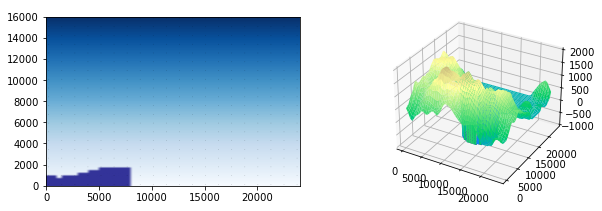

In [17]:
%matplotlib inline

def draw():
    #draw scene
    img=plt.cm.Blues(z/z.max())
    img=np.where(mask[...,None],img,plt.cm.terrain(0))
    cloud_alpha=np.clip(rhobar*Qc*1000/.1,0,1)[...,None]
    cloud_blend=np.clip(rhobar*Qc*1000/2,0,1)[...,None]
    cloud_color=(1-cloud_blend)*np.array([1,1,1,1])+cloud_blend*np.array([0,0,0,1])
    img=(1-cloud_alpha)*img+cloud_alpha*cloud_color
    rain_alpha=np.clip(rhobar*Qr*1000/.5,0,.5)[...,None]
    rain_color=np.array([.3,.4,.5,1])
    img=(1-rain_alpha)*img+rain_alpha*rain_color
    
    plt.subplot(421)
    show_quiver_section(xy,u,scale=50,numbers=[20,20],alpha=.3)
    show_image_section(img,is_rgb=True)
    
    plt.gcf().add_subplot(4,2,2,projection='3d',computed_zorder=False)
    show_terrain(xy,np.where(water_mask[...,0],-1000,terrain),cmap='terrain',vmin=-1000,vmax=4000,zorder=0)
    show_isosurface(rhobar*Qc,rel_level=.9,step_res=24,abs_level=.5e-4,alpha=.5,zorder=0.1)
    
    T=get_temperature(theta,pbar)
    
    plt.subplot(423)
    plt.title('Relative Humidity')
    show_contour_section(xy,get_relative_humidity(T,pbar,Qv)*100,fmt=lambda x:f'{x:.1f}%')
    show_quiver_section(xy,u,scale=50,numbers=[20,20])
    
    plt.subplot(424)
    plt.title('Δθ')
    show_contour_section(xy,theta-thetabar,fmt=lambda x:f'{x:+.2f}℃')
    show_quiver_section(xy,u,scale=50,numbers=[20,20])

    plt.subplot(425)
    plt.title('Relative Humidity')
    show_contour_section(xy,get_relative_humidity(T,pbar,Qv)*100,axis=2,position=2000,fmt=lambda x:f'{x:.1f}%')
    show_quiver_section(xy,u,axis=2,position=2000,scale=50,numbers=[20,20])
    
    plt.subplot(426)
    plt.title('Δθ')
    show_contour_section(xy,theta-thetabar,axis=2,position=1000,fmt=lambda x:f'{x:+.2f}℃')
    show_quiver_section(xy,u,axis=2,position=1000,scale=50,numbers=[20,20])
    
    plt.subplot(427)
    plt.title('Relative Humidity')
    show_contour_section(xy,get_relative_humidity(T,pbar,Qv)*100,axis=2,position=2000,fmt=lambda x:f'{x:.1f}%')
    show_quiver_section(xy,u,axis=2,position=8000,scale=50,numbers=[20,20])
    
    plt.subplot(428)
    plt.title('Δθ')
    show_contour_section(xy,theta-thetabar,axis=2,position=2000,fmt=lambda x:f'{x:+.2f}℃')
    show_quiver_section(xy,u,axis=2,position=8000,scale=50,numbers=[20,20])
    
    #captions
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    umax=np.max(u,axis=None)
    mv,mc,mr=calc_total_water(Qv=Qv,Qc=Qc,Qr=Qr,rhobar=rhobar,cellVolumes=np.prod(cellSizes))
    Ek=calc_total_kinematic_energy(u,rhobar)
    plt.suptitle(f'T={time:.2f}s, umax={umax:.2f}m/s, Ektot={Ek:.3e}J\n'+
                 f'mv={mv:.3e}kg, mc={mc:.3e}kg, mr={mr:.3e}kg, mtot={mv+mc+mr:.3e}kg')
    
    
plt.figure(figsize=(10,16))
draw()
plt.show()

<IPython.core.display.Javascript object>


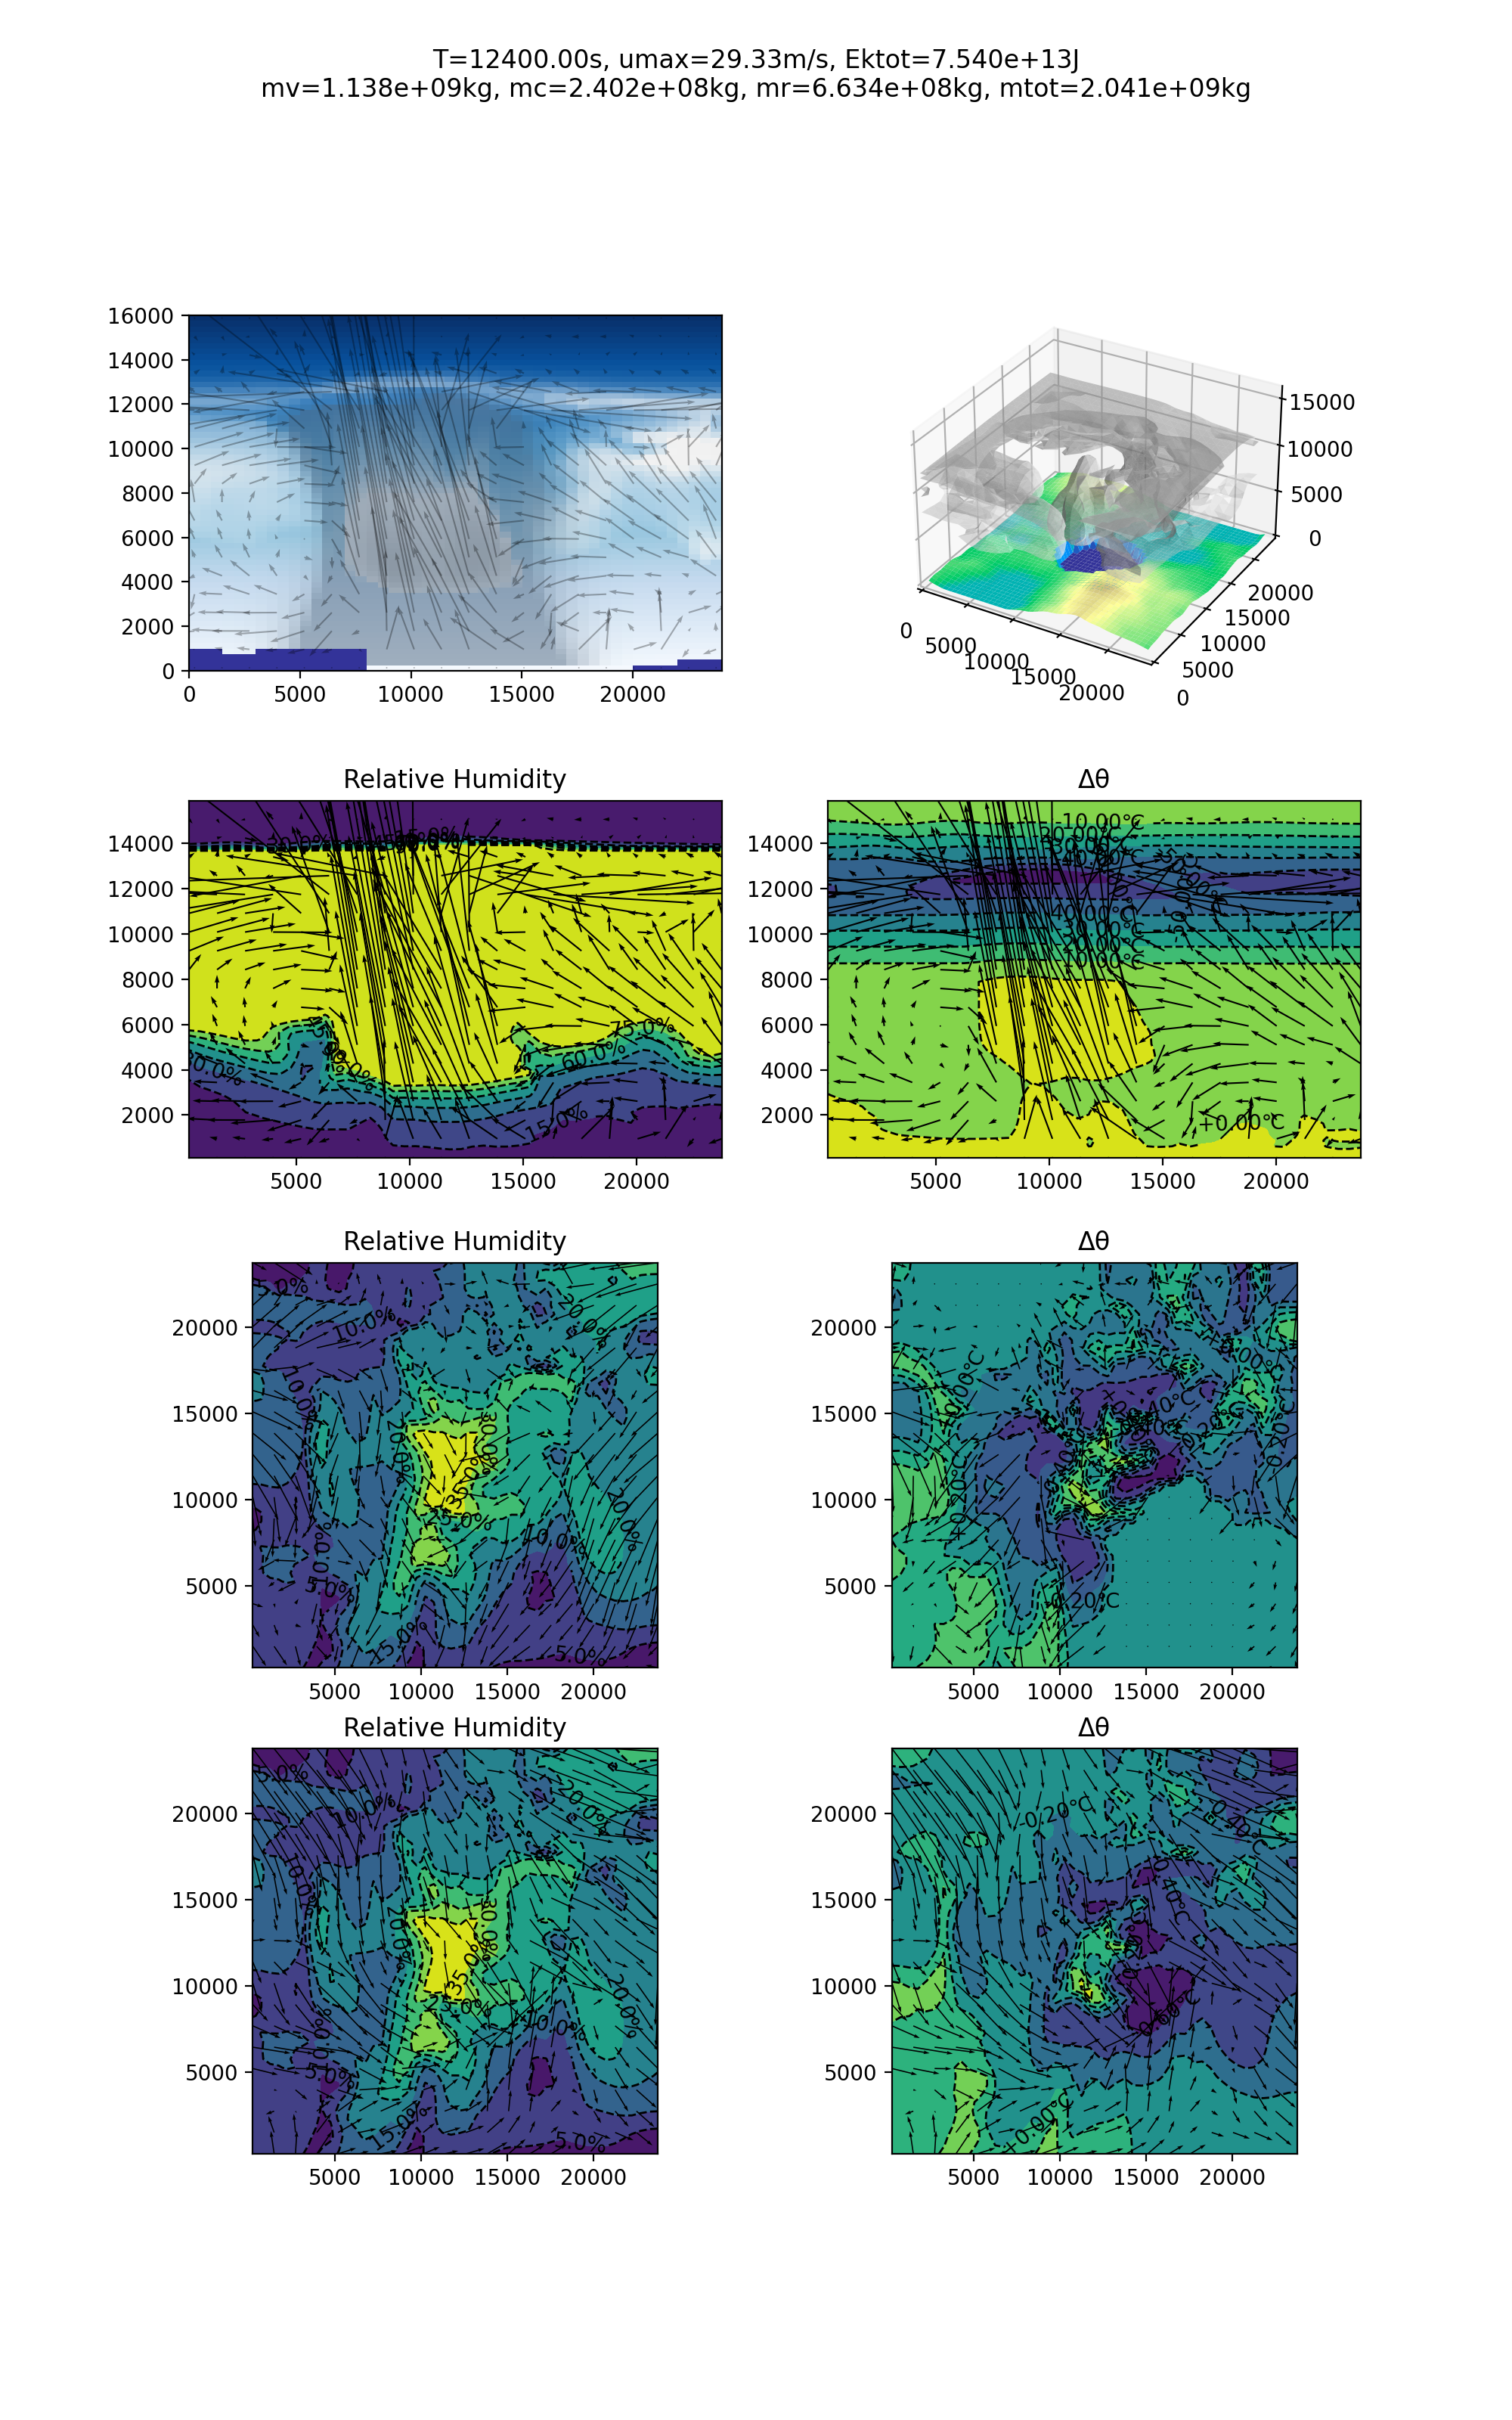

  0%|          | 0/1440 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/wenhan/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3971112/4005850385.py", line 13, in <module>
    update_graph()
  File "/tmp/ipykernel_3971112/4005850385.py", line 8, in update_graph
    fig.canvas.draw()
  File "/home/wenhan/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_webagg_core.py", line 188, in draw
    super().draw()
  File "/home/wenhan/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py", line 436, in draw
    self.figure.draw(self.renderer)
  File "/home/wenhan/anaconda3/lib/python3.9/site-packages/matplotlib/artist.py", line 74, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
  File "/home/wenhan/anaconda3/lib/python3.9/site-packages/matplotlib/artist.py", line 51, in draw_wrapper
    return draw(artist, renderer)
  File "/home/wenhan/a

TypeError: object of type 'NoneType' has no len()

In [7]:
%matplotlib notebook

fig=plt.figure(figsize=(10,16),dpi=100)
plt.ion()
def update_graph():
    plt.clf()
    draw()
    fig.canvas.draw()

    
for _iter in tqdm(range(int(4*3600/timeStep))):
    if _iter%10==0:
        update_graph()
        #sleep(1)
    
    ur=u.copy()
    ur[...,2]=ur[...,2]-rain_droplet_terminal_velocity
    
    theta=advect(theta,u)
    Qv=advect(Qv,u)
    Qc=advect(Qc,u)
    Qr=advect(Qr,ur)
    u=advect_velocity_MacCormack(u)
    
    B=get_buoyancy_acceleration(T_ratio=theta/thetabar,Qv=Qv,Qc=Qc,Qr=Qr)
    u=add_buoyancy(u,acceleration=B)
    u=add_coriolis_force(u)

    theta=diffuse(theta,amount=diffuse_Q*timeStep,nIter=2)
    Qv=diffuse(Qv,amount=diffuse_T*timeStep,nIter=2)
    u=diffuse(u,amount=viscosity*timeStep,nIter=2)
    
    theta,Qv,Qc,Qr=update_cloud_model(theta,Qv,Qc,Qr,pbar=pbar,timeStep=timeStep)

    u,w=amplify_vorticity(u,vorticity_eps)

    u,p=solve_pressure(u,density=rhobar,nIter=10,old_pressure=p)
    
    def apply_boundary_(x,x_bc):
        shape=x.shape
        x=x.reshape(shape[:3]+(-1,))
        x_bc=x_bc.reshape(shape[:3]+(-1,))
        x=np.where(mask[...,None],x,x_bc)
        return apply_dirichlet_boundary_(x,x_bc).reshape(shape)
    
    u=apply_boundary_(u,u_bc)
    theta=apply_boundary_(theta,theta_bc)
    Qv=apply_boundary_(Qv,Qv_bc)
    Qr=apply_boundary_(Qr,Qr_bc)
    
    time=time+timeStep
    
plt.show()


# TODO

add friction

vorticity eps has bug!

rain falling

rain friction

finer structure where do they come from

how to speed up

# Spherical Flow

In [58]:
import math
math.prod(T.shape[2:])

1

# 3D Spherical Flow

# Radiance Effect

# Ocean current

# Glacier

# Biomes